# 分类分析

回归和分类是数据分析的两大重要任务，它们最大的区别在于因变量的类别：回归分析的因变量是连续变量；分类分析的因变量是分类属性变量。与回归分析一样，在进行分类分析之前，我们必须要弄清楚我们建模的目的是推断还是预测，任务的不同将很大程度决定我们建模所采用的方法论的不同——如果是以推断/分析为主，那么我们在建模时所采用的模型最好是易于解释的白盒模型，如一众线性模型；如果是以预测为主，则我们建模的依据主要是预测的精度，模型的可解释性相对而言不那么重要。

对于分类任务而言，当前预测精度高的模型基本上都是深度学习/机器学习模型（如：支持向量机、随机森林、Xgboost等），而这些模型的可解释性一般都很差，我们难以在这些模型中寻找变量之间的依存信息。而如果我们追求分类模型的可解释性，探究各自变量对分类决策的影响，那么使用线性模型框架下的分类模型就比较合适了（如：Logistic回归、Probit回归等）。

本次主要涉及到解释性较强的分类模型。

分类：

逻辑回归、朴素贝叶斯、决策树、随机森林、SVM

评估方式：混淆矩阵、分类报告

评估指标：查准率、召回率、F1得分

模型选择：交叉验证、验证曲线、学习曲线、网格搜索

# 1. 二分类问题

## 1.1 线性回归模型是如何处理分类问题的？

二分类本质上还是回归问题，只不过回归得到的是某个类别的概率，然后需要将概率映射到类别。

比如：我们想研究被ST的公司其背后的因素，并尝试通过利用公司的财务指标提前预测某上市公司在未来是否会被ST。而在这项任务中，因变量就是公司是否会被ST，数学表示为：
$$
y= \begin{cases}1, & S T \\ 0, & \text { Otherwise }\end{cases}
$$

**概率的映射**

回归问题因变量确定，分类问题中概率的形式是需要人为确定的，即我们要确定如何将线性模型的直接输出值$y$映射成概率值$P(y=1 \mid x)$。

多元线性模型
$$
y=\beta_{0}+\beta_{1} x_{1}+\cdots+\beta_{k} x_{k}+u
$$
的输出值$y$是一个连续变量，而概率也是一个连续的变量，那么我们能不能让这个输出值$y=P(y=1 \mid x)$呢？即有
$$
P(y=1\mid x)=y
$$
这样做有一个最大的缺点——$\hat{y}$可能不在区间(0,1)内，而概率只能在(0,1)区间内。

因此需要将$y$放在一个映射函数中将之映射为一个概率。而映射函数的不同决定了模型的形式、解释、训练方法的不同。

(1)若映射函数为Logistic函数
$$
G(y)=\frac{1}{1+e^{-y}}
$$
则整个预测模型被称为Logistic线性回归模型

(2)若映射函数为Probit函数
$$
\Phi(y)=P(Y \leq y)=\int_{-\infty}^{y} \frac{1}{\sqrt{2 \pi}} \exp \left(-\frac{1}{2} x^{2}\right) d x
$$
则整个预测模型被称为Probit线性回归模型。注意到，Probit函数实际上就是标准正态分布的累积函数。

这两个函数的形状如下：


In [1]:
# 加载基础包
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats
import matplotlib.pyplot as plt

# plt.style.use('ggplot')

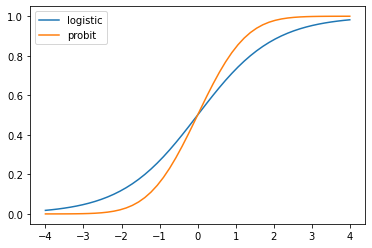

In [2]:
# 具有单调递增性质，且值域位于(0,1)之间
def logistic(y):
    return 1 / (1 + np.exp(-y))

def probit(y):
    return stats.norm.cdf(y, loc=0, scale=1)

y = np.linspace(-4, 4, 50)
logistic_y = logistic(y)
probit_y = probit(y)
plt.plot(y, logistic_y, label='logistic')
plt.plot(y, probit_y, label='probit')
plt.legend()

## 1.2 Logistic线性回归模型

**模型形式**

记$y=x^{\prime} \beta=\beta_{0}+\beta_{1} x_{1}+\cdots+\beta_{k} x_{k}$，则Logistic回归模型形式为
$$
P(y=1 \mid x)=p\left( x \right) =\frac{1}{1+e^{-y}}=\frac{1}{1+e^{-x^{'}\beta}}
$$
以上形式还可以恒等变换为以下形式，便于我们对模型进行解释
$$
\log \left(\frac{p(x)}{1-p(x)}\right)=\beta_{0}+\beta_{1} x_{1}+\cdots+\beta_{k} x_{k}
$$
这个模型形式告诉我们，Logistic回归模型与一般多元回归模型的一大区别在于，前者的因变量是一个有关概率$p\left( y=1|x \right) $的函数，而后者的因变量只是其本身。

**· 模型解释**

要想解释这个模型中每个变量系数的意义，首先要弄清楚$\log \left(\frac{p(x)}{1-p(x)}\right)$的含义。

如果把$y=1$看作“成功”，$y=0$看作失败，则$p(x) /[1-p(x)]$就是成功与失败的概率比，被称为胜率(odd)。因此对于系数$\beta_j$，我们的解释是：当其他自变量不变时，变量$x_i$提升一个单位，胜率odd会提升$\beta_j \%$。

In [3]:
# 读取数据
ST = pd.read_csv('./data/ST.csv')
ST.head()

,ARA,ASSET,ATO,ROA,GROWTH,LEV,SHARE,ST
0,0.192310,19.856048,0.0052,0.087710,-0.950727,0.445880,26.89,0
1,0.220120,20.910863,0.0056,0.016820,-0.942656,0.398686,39.62,0
2,0.325292,19.352623,0.0166,0.042468,-0.937440,0.303348,26.46,0
3,0.025729,21.438928,0.0028,0.018152,-0.852995,0.758250,60.16,0
4,0.533591,21.613339,0.2552,0.004147,-0.816704,0.726875,54.24,1


In [4]:
st_logit = sm.formula.logit(
    'ST~ARA+ASSET+ATO+ROA+GROWTH+LEV+SHARE', data=ST).fit()
print(st_logit.summary())

Optimization terminated successfully.
         Current function value: 0.183849
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                     ST   No. Observations:                  684
Model:                          Logit   Df Residuals:                      676
Method:                           MLE   Df Model:                            7
Date:                Sun, 24 Jul 2022   Pseudo R-squ.:                  0.1084
Time:                        23:46:28   Log-Likelihood:                -125.75
converged:                       True   LL-Null:                       -141.04
Covariance Type:            nonrobust   LLR p-value:                 7.477e-05
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -8.8692      4.636     -1.913      0.056     -17.955       0.217
ARA            4.8797      1.

## 1.3 Probit线性回归模型

**· 模型形式**

Probit回归模型形式为
$$
p(x)=\Phi\left(x^{\prime} \beta\right)
$$
其中，$\Phi$就是标准正态分布的累积函数

**· 模型解释**

Probit模型的系数解释不直观，但可以确定的是，当$\beta_j>0$时，$x_j$的增加会导致响应概率$p(x)$的增加。

In [5]:
st_probit = sm.formula.probit(
    'ST~ARA+ASSET+ATO+ROA+GROWTH+LEV+SHARE', data=ST).fit()
print(st_probit.summary())

Optimization terminated successfully.
         Current function value: 0.183018
         Iterations 7
                          Probit Regression Results                           
Dep. Variable:                     ST   No. Observations:                  684
Model:                         Probit   Df Residuals:                      676
Method:                           MLE   Df Model:                            7
Date:                Sun, 24 Jul 2022   Pseudo R-squ.:                  0.1124
Time:                        23:46:28   Log-Likelihood:                -125.18
converged:                       True   LL-Null:                       -141.04
Covariance Type:            nonrobust   LLR p-value:                 4.612e-05
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.9545      2.210     -2.242      0.025      -9.286      -0.623
ARA            2.6467      0.

## 1.5 分类预测

### 1.5.1 模型预测的原理

以Logit模型为例，简述模型预测的原理。

对于一组给定的解释变量取值$x_0$，将之代入模型中计算概率值$p(x)$
$$
\hat{p}\left(x_{0}\right)=\frac{e^{x_{0}^{\prime} \hat{\beta}}}{1+e^{x_{0}^{\prime} \hat{\beta}}}
$$
这一概率是在样本自变量$x=x_0$下，$y_0=1$的概率。

In [6]:
# 输出st_logit模型对ST数据集前五个样本的预测p(x)
logit_pred = st_logit.predict()
print(logit_pred[:5].round(3))

[0.175 0.203 0.207 0.162 0.673]



根据概率判断样本应当被划分为1类还是0类。规定一个阈值$\alpha$，当概率$p(x)>\alpha$时，样本被划分为1类，否则划分为0类。即
$$
\hat{y}_{0}= \begin{cases}1, & \hat{p}\left(x_{0}\right)>\alpha \\ 0, & \text { Otherwise }\end{cases}
$$
一般情况下，阈值$\alpha$默认为0.5。

In [7]:
# 我们构建一个判定函数，使其可以输出st_logit模型对ST数据集前五个样本在阈值为0.5时的预测判定
logit_res = list()
for i in np.arange(len(logit_pred)):
    if logit_pred[i] > 0.5:  # 阈值
        logit_res.append(1)
    else:
        logit_res.append(0)

# 输出前五个样本的预测
print('前五个样本的预测结果：{}'.format(logit_res[:5]))


前五个样本的预测结果：[0, 0, 0, 0, 1]


### 1.5.2 预测结果呈现——混淆矩阵与多指标

**· 混淆矩阵**

使用模型完成预测后，我们想要直观地获知模型预测的效果——模型预测正确率是多少？有多少ST=1样本被正确预测了，又有多少ST=0的样本被正确预测了？关于这些问题，我们可以使用分类问题中常用的工具——**混淆矩阵**来解决。

对于二分类问题，混淆矩阵的形式如下图所示

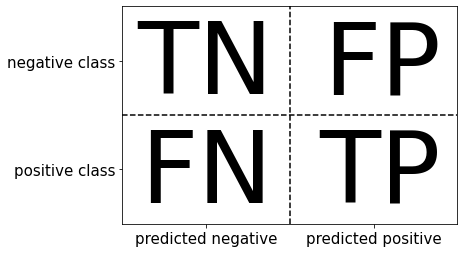

In [8]:
import mglearn

mglearn.plots.plot_binary_confusion_matrix()

预测值为正例，记作P（Positive）

预测值为负例，记作N（Negative）

预测值与真实值相同，记为T（True）

预测值与真实值相反，记为F（False)

TP为真正例，即预测值与真实值相同，而且都是正例

FP为假正例，即预测值与真实值相反，预测值为P

FN为假负例，即预测值与真实值相反，预测值为N

TN为真负例，即预测值与真实值相同，而且都是反例

TPR：真阳性率, 在所有实际为阳性的样本中，被正确地判断为阳性之比率。TPR=TP/(TP+FN)

FPR：假阳性率, 在所有实际为阴性的样本中，被错误地判断为阳性之比率。FPR=FP/(FP+TN)

In [9]:
# 在阈值0.5的前提下，logit模型的预测结果如下
from sklearn.metrics import confusion_matrix

confusion_matrix(ST.ST,logit_res)  # 注意：第一个值输入的是真实的标签集，第二个值输入的是预测的标签集

array([[647,   1],
       [ 35,   1]], dtype=int64)

**多分类指标**

**正确率(Accuracy)** ，分类精度的公式为
$$
Accuracy=\frac{TP+TN}{TP+TN+FP+FN}
$$

**精确率(Precision)** 衡量的是所有被预测为正类的样本中，预测正确的比例，公式为：
$$
Precision=\frac{TP}{TP+FP}
$$

**召回率(Recall)** 衡量的是所有正类样本中，预测正确的比例，公式为：
$$
\mathrm{Re}call=\frac{TP}{TP+FN}
$$

**F分数(F-score)** 是精确率与召回率的调和平均，是两者的综合取舍，公式为：
$$
F-score=2\cdot \frac{precision\cdot recall}{precision+recall}
$$

In [10]:
# 分类报告-精确率、召回率、f分数
from sklearn.metrics import classification_report
print(classification_report(ST.ST, logit_res))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       648
           1       0.50      0.03      0.05        36

    accuracy                           0.95       684
   macro avg       0.72      0.51      0.51       684
weighted avg       0.93      0.95      0.92       684



### 1.5.3 对抗不平衡数据集——改变阈值

我们在前面看到了在阈值$\alpha=0.5$下，logit模型对ST=1的小样本的分类非常糟糕，这是为什么呢？

事实上，不平衡的数据集会导致模型的训练产生偏好性，由于ST=0的样本远远多于ST=1的样本，模型会更多地学习到ST=0的样本特征，而对ST=1的样本特征学习不足，于是对于一个未知样本，模型会更倾向于将它预测成大样本的类别。

In [11]:
# 观察前50个样本的预测p
print(logit_pred[:50] > 0.5)

[False False False False  True False False False False False  True False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]


In [12]:
# 调整阈值
logit_res=list()
for i in np.arange(len(logit_pred)):
    if logit_pred[i] > 0.0526: #阈值
        logit_res.append(1)
    else:
        logit_res.append(0)

# 混淆矩阵
print(confusion_matrix(ST.ST,logit_res))

# 综合报告
print(classification_report(ST.ST,logit_res))

[[463 185]
 [ 11  25]]
              precision    recall  f1-score   support

           0       0.98      0.71      0.83       648
           1       0.12      0.69      0.20        36

    accuracy                           0.71       684
   macro avg       0.55      0.70      0.51       684
weighted avg       0.93      0.71      0.79       684



可以发现，在调整了阈值后，以ST=1为正类的召回率显著提升，更多的正类样本被正确划分了。

但与此同时，以ST=1为正类的精确率却下降了很多，假反例大大增加，这就是调整阈值所付出的代价。事实上，调整阈值是一把“双刃剑”，对于一个既定的模型，改变阈值并不会改变模型的预测性能，它只能改变样本预测的分布，使分布更符合我们实际的需求。如果需要改进预测效果，要么换一种精度更高的模型，要么进行调参处理。

# 2. 多分类问题

sklearn也具有做Logistic回归的功能，但它注重预测结果输出，而在统计推断结果的可视化上，sklearn做的远远不如statsmodels。

因此本章节我们不介绍多分类Logistic回归的统计推断，只学习如何预测。

## 2.1 多分类Logistic回归的两种算法

多分类Logistic回归主要有两种：

一种是修改概率映射函数，将其中一个类作为基类，通过修改过后的映射函数获得k-1个对数胜率；

另一种是“一对其余”(one-vs-rest)，对每个类别都建立一个二分类Logistic回归，将本类别的样本定义为0，其余类别的样本定义为1，在所有类别的分类器中，概率$p$最高的类别就是实际判定的类别。

### 2.1.1 算法1：修改概率映射函数

**原理介绍**

我们回顾一下二分类Logistic回归的模型
$$
\log \left(\frac{p(x)}{1-p(x)}\right)=\beta_{0}+\beta_{1} x_{1}+\cdots+\beta_{k} x_{k}
$$
实际上我们可以将等式稍微变化一下
$$
\log \left( \frac{p(y=1|x)}{p(y=0|x)} \right) =\beta _0+\beta _1x_1+\cdots +\beta _kx_k
$$
它实际上比较的是1类和0类的概率。

而在多分类问题上，类别不仅仅有0和1，怎么比较其他类别的概率呢？我们可以选取一个类别作为基类（在这里我们选择0类），像上述公式一样分别计算0类与剩余类别之间的对数概率之比
$$
g_m\left( x \right) =\log \left( \frac{p(y=m|x)}{p(y=0|x)} \right) =\beta _{m0}+\beta _{m1}x_1+\cdots +\beta _{mk}x_k\text{，}m=1,…,M
$$
有M个类别，就会有M-1个函数，这些函数的实际意义是“目标类别$j$与基类$0$的对数胜率”。

计算出了M-1个函数$g_m\left( x \right)$后，我们便可以使用一个变式的Logit映射函数计算每个类别的条件概率$P(y=m\mid \mathbf{x})$
$$
P(y=m\mid \mathbf{x})=\frac{e^{g_m(\mathbf{x})}}{1+\sum_{m=1}^{M-1}{e^{g_m(\mathbf{x})}}}
$$

### 2.1.2 算法2：一对其余算法

许多线性分类模型只适用于二分类问题，它们不能像Logistic回归一样有多分类的推广。于是，将二分类算法推广至多分类算法的一种常见方法就是“一对其余”。这种方法的思想非常简单，就是对每个类别都学习一个二分类模型，将这个类别与所有其余类别尽量分开，这样会生成与类别个数M相同个数的分类器，每个分类器都会输出一个概率，概率最高者“胜出”，并将这个类别的标签返回作为预测结果。

sklearn中的LogisticRegression的多分类形式就是采用了这样的算法。我们用一个含有三个类别、两个特征的玩具数据集来实操一波，来看看模型是如何处理多分类问题的。

In [13]:
import mglearn
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.datasets import make_blobs
X, y = make_blobs(random_state=42)
print('前5个样本的X特征',X[:5])
print('前5个样本的y标签',y[:5])

前5个样本的X特征 [[-7.72642091 -8.39495682]
 [ 5.45339605  0.74230537]
 [-2.97867201  9.55684617]
 [ 6.04267315  0.57131862]
 [-6.52183983 -6.31932507]]
前5个样本的y标签 [2 1 0 1 2]


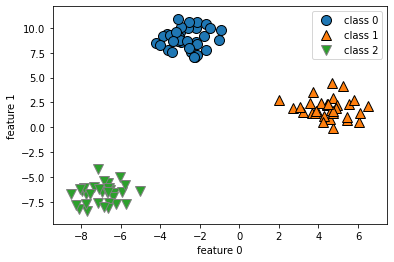

In [14]:
# 利用散点图对数据集进行可视化
mglearn.discrete_scatter(X[:,0], X[:,1], y)
plt.xlabel('feature 0')
plt.ylabel('feature 1')
plt.legend(['class 0','class 1','class 2'])

训练一个多分类Logistic回归模型，对上述样本进行分类。

In [15]:
from sklearn.linear_model import LogisticRegression
logis_multi = LogisticRegression(multi_class='multinomial').fit(X,y)
# 截距
print(logis_multi.intercept_)
# 系数
print(logis_multi.coef_)

[-1.63102014  1.85764971 -0.22662957]
[[-0.38486163  0.62874226]
 [ 0.74106233 -0.17664082]
 [-0.3562007  -0.45210144]]


根据输出，我们可以给出三个“一对其余”的模型公式，如第一个模型的公式就是
$$
\log \left( \frac{p\left( y=0|x \right)}{p\left( y\ne 0|x \right)} \right) =-1.63102014+-0.38486163x_1+0.62874226x_2
$$
我们将这三个分类器所代表的直线画到上图中

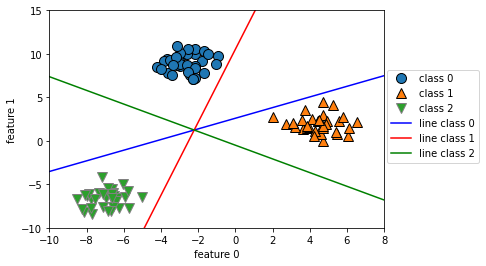

In [16]:
mglearn.discrete_scatter(X[:,0],X[:,1],y)
line_x=np.linspace(-15,15)
for coef,intercept,color in zip(logis_multi.coef_,logis_multi.intercept_,['b','r','g']):
    plt.plot(line_x,-(line_x*coef[0]+intercept)/coef[1],c=color)
plt.ylim(-10,15)
plt.xlim(-10,8)
plt.xlabel('feature 0')
plt.ylabel('feature 1')
plt.legend(['class 0','class 1','class 2','line class 0','line class 1','line class 2'],loc=(1.01,0.3))

# 3. 分类问题实操流程

## 3.1 划分训练集/测试集

In [17]:
# 以上面的make_blobs数据集为例
from sklearn.model_selection import train_test_split

# 数据集切分
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25, random_state=0)  # test_size为测试集数据量占原始数据的比例

print('train_size', len(X_train)/len(X))
print('test_size', len(X_test)/len(X))

train_size 0.75
test_size 0.25


## 3.2 训练模型/模型预测

切分完数据集后，我们便可以进行模型训练了。以logistic回归为例

In [18]:
from sklearn.linear_model import LogisticRegression
# 使用训练集进行训练
logit_multi=LogisticRegression(multi_class='multinomial').fit(X_train,y_train)
# 使用测试集进行预测
y_pred=logis_multi.predict(X_test)
# 查看预测结果
print(y_pred)

[1 0 0 2 2 1 2 0 2 0 2 0 1 0 1 2 2 0 2 1 0 2 1 2 1]


## 3.3 预测结果分析

完成预测后，我们需要对模型的预测结果进行分析，常见的分析指标有：分类精度，精确率，召回率，f分数等；当然，我们可以输出混淆矩阵。

In [19]:
# 查看分类精度
print('测试集分类精度',logis_multi.score(X_test,y_test)) # 传入需要进行预测数据集自变量与真实标签集

# 混淆矩阵
display(confusion_matrix(y_test,y_pred))

# 综合指标
print(classification_report(y_test,y_pred))

测试集分类精度 1.0


array([[ 8,  0,  0],
       [ 0,  7,  0],
       [ 0,  0, 10]], dtype=int64)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00        10

    accuracy                           1.00        25
   macro avg       1.00      1.00      1.00        25
weighted avg       1.00      1.00      1.00        25



# 二分类：信贷风险评估

我们想知道银行贷款审批中是否存在种族歧视，这是一个非常典型的“推断”问题，于是可采用线性回归分类模型对该问题进行探究。

本次习题使用数据loanapp.dta，所使用的变量解释如下：

因变量：
<br>
· approve：贷款是否被批准（0为不批准、1为批准）

自变量：
<br>
· white：种族哑变量（0为黑人，1为白人）
<br>
· obrat：债务占比

In [20]:
# 由于数据集含有缺失值，先去除含有缺失值的样本
loan=pd.read_stata('./data/loanapp.dta')
# 选取要用的变量组成新的数据集
loan=loan[["approve","white","hrat","obrat","loanprc","unem","male","married","dep","sch","cosign","chist","pubrec","mortlat1","mortlat2","vr"]]
loan.dropna()  # 去除含缺失值样本

,approve,white,hrat,obrat,loanprc,unem,male,married,dep,sch,cosign,chist,pubrec,mortlat1,mortlat2,vr
1,0.0,1.0,22.540001,34.099998,0.800000,3.2,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
2,1.0,1.0,19.000000,26.000000,0.895105,3.9,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1.0,1.0,24.000000,37.000000,0.600000,3.1,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
4,1.0,1.0,25.100000,32.099998,0.895522,4.3,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5,1.0,1.0,21.000000,33.000000,0.804348,3.2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1984,1.0,1.0,20.299999,29.299999,0.897727,4.3,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1985,1.0,1.0,8.000000,20.000000,0.111111,3.2,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1986,1.0,1.0,56.099998,60.500000,1.000000,3.2,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1987,1.0,1.0,16.000000,17.000000,0.455814,3.2,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


**使用python进行实操并回答以下问题**

（1）：先考虑一个线性概率模型
$$approve = \beta_0+\beta_1white+u$$

如果存在种族歧视，那么$\beta1$的符号应该大于0。因为黑人对应的white=0，所以不容易从黑人角度分析。相反的，因为对于白人white=1，其对应的approve=1，样本中白人:黑人=1681:308，因此如果存在种族歧视，那么就需要保证大部分的白人都能成功申请，所以要保证$\beta1$>0


In [21]:
loan['white'].value_counts()

1.0    1681
0.0     308
Name: white, dtype: int64


（2）：用OLS估计上述模型，解释参数估计的意义，其显著性如何？实际上大吗？



In [22]:
loanapp_lm = sm.formula.ols("approve~white", data=loan).fit()
print(loanapp_lm.summary())

                            OLS Regression Results                            
Dep. Variable:                approve   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     102.2
Date:                Sun, 24 Jul 2022   Prob (F-statistic):           1.81e-23
Time:                        23:52:32   Log-Likelihood:                -555.54
No. Observations:                1989   AIC:                             1115.
Df Residuals:                    1987   BIC:                             1126.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7078      0.018     38.806      0.0

参数$\beta1$的估计值为0.2006。

其t值大于0，我们的原假设应该是$\beta1$>0
，而备择假设却是小于0，那么此时的p值肯定是大于0.5的，因此我们不能拒绝原假设，可以认为存在种族歧视。但实际上，黑人的approve都为0.7078，是否通过申请还得看具体的阈值。


（3）：在上述模型中加入数据集中的其他所有自变量，此时white系数发生了什么变化？我们仍然可以认为存在黑人歧视现象吗？


In [23]:
formula = "approve~" + "+".join(loan.columns[1:])
loanapp_lm_all = sm.formula.ols(formula, data=loan).fit()
print(loanapp_lm_all.summary())

                            OLS Regression Results                            
Dep. Variable:                approve   R-squared:                       0.166
Model:                            OLS   Adj. R-squared:                  0.159
Method:                 Least Squares   F-statistic:                     25.86
Date:                Sun, 24 Jul 2022   Prob (F-statistic):           1.84e-66
Time:                        23:56:22   Log-Likelihood:                -429.26
No. Observations:                1971   AIC:                             890.5
Df Residuals:                    1955   BIC:                             979.9
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9367      0.053     17.763      0.0

系数$\beta1$下降为0.1288，但是其t值仍然>0，与（2）相同，仍然可以认为存在种族歧视


（4）：允许种族效应与债务占比(obrat)有交互效应，请问交互效应显著吗？请解读这种交互效应。


In [24]:
formular_ur = "approve~" + "+".join(loan.columns[1:]) + "+I(white*obrat)"
loanapp_lm_ur = sm.formula.ols(formular_ur, data=loan).fit()
print(loanapp_lm_ur.summary())

formular_r = "approve~" +"+".join(loan.columns[2:])
loanapp_lm_r = sm.formula.ols(formular_r, data=loan).fit()

from statsmodels.stats.anova import anova_lm
anova_lm(loanapp_lm_r, loanapp_lm_ur)

                            OLS Regression Results                            
Dep. Variable:                approve   R-squared:                       0.171
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     25.17
Date:                Sun, 24 Jul 2022   Prob (F-statistic):           2.37e-68
Time:                        23:57:27   Log-Likelihood:                -422.99
No. Observations:                1971   AIC:                             880.0
Df Residuals:                    1954   BIC:                             974.9
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            1.1806      0.087  

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,1956.0,182.282812,0.0,NaN,NaN,NaN
1,1954.0,177.262206,2.0,5.020606,27.671617,1.410622e-12


从t检验的结果来看，交互项的p值为0.000，因此拒绝原假设，即不能认为不同人种间的债务占比相同；而F检验的结果也是相当显著，拒绝原假设，也就是说不同人种的申请成功率存在明显差异。综合来看，不同人种申请成功率存在明显差异，可以认为有债务占比的影响。


（5）：使用logit模型与probit模型重新（4）中的模型，观察变量系数及其显著性的变化。

In [25]:
loanapp_logit = sm.formula.logit(formula, data=loan).fit()
print(loanapp_logit.summary())

loanapp_probit = sm.formula.probit(formula, data=loan).fit()
print(loanapp_probit.summary())

Optimization terminated successfully.
         Current function value: 0.304666
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                approve   No. Observations:                 1971
Model:                          Logit   Df Residuals:                     1955
Method:                           MLE   Df Model:                           15
Date:                Sun, 24 Jul 2022   Pseudo R-squ.:                  0.1863
Time:                        23:58:15   Log-Likelihood:                -600.50
converged:                       True   LL-Null:                       -737.98
Covariance Type:            nonrobust   LLR p-value:                 8.693e-50
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.8017      0.595      6.393      0.000       2.636       4.967
white          0.9378      0.

相比于（3）中的模型，系数增加幅度较大，但是显著性没有明显变化，都是接受原假设，认为人种对贷款申请成功率有影响。

# 多分类：鸢尾花分类问题

鸢尾花分类问题是经典的多分类问题，我们使用sklearn的logisticRegression求解该问题。

In [27]:
# 下载数据集
from sklearn.datasets import load_iris
iris_dataset=load_iris()

# 提取数据集中的自变量集与标签集
iris_data=iris_dataset['data'] # 自变量
iris_target=iris_dataset['target'] # 标签集

**使用python进行实操并回答以下问题**

（1）：将原数据集划分为训练集与测试集，两者样本比例为3:1。


In [28]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(iris_data, iris_target, test_size=0.25, random_state=42)
print(f"训练集大小：{len(x_train)}")
print(f"测试集大小：{len(x_test)}")

训练集大小：112
测试集大小：38



（2）：使用训练集数据训练logistic回归模型，并分别对训练集与测试集数据进行预测，并将预测的结果分别储存在两个自定义的变量中。


In [34]:
lr = LogisticRegression(multi_class="multinomial", max_iter=1000).fit(x_train, y_train)
y_pred_train = lr.predict(x_train)
y_pred_test = lr.predict(x_test)
print(y_train)
print(y_pred_train)
print(y_test)
print(y_pred_test)

[0 0 2 1 1 0 0 1 2 2 1 2 1 2 1 0 2 1 0 0 0 1 2 0 0 0 1 0 1 2 0 1 2 0 2 2 1
 1 2 1 0 1 2 0 0 1 1 0 2 0 0 1 1 2 1 2 2 1 0 0 2 2 0 0 0 1 2 0 2 2 0 1 1 2
 1 2 0 2 1 2 1 1 1 0 1 1 0 1 2 2 0 1 2 2 0 2 0 1 2 2 1 2 1 1 2 2 0 1 2 0 1
 2]
[0 0 2 1 1 0 0 1 2 2 1 2 1 2 1 0 2 1 0 0 0 1 2 0 0 0 1 0 1 2 0 1 2 0 2 2 1
 1 2 1 0 1 2 0 0 1 2 0 2 0 0 2 1 2 2 2 2 1 0 0 2 2 0 0 0 1 2 0 2 2 0 1 1 2
 1 2 0 2 1 2 1 1 1 0 1 1 0 1 2 2 0 1 2 2 0 2 0 1 2 2 1 2 1 1 2 2 0 1 1 0 1
 2]
[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0]
[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0]



（3）：使用函数接口计算出：模型对训练集数据的分类正确率、模型对测试集数据的分类正确率，比较它们孰高孰低，并思考为什么会有这样的差异。


In [37]:
confusion_matrix_train = confusion_matrix(y_train, y_pred_train)
print("训练集数据:", np.diagonal(confusion_matrix_train).sum() / np.sum(confusion_matrix_train))
confusion_matrix_test = confusion_matrix(y_test, y_pred)
print("测试集数据:", np.diagonal(confusion_matrix_test).sum() / np.sum(confusion_matrix_test))

训练集数据: 0.9642857142857143
测试集数据: 1.0


按照常理而言，模型对训练集的拟合程度应该更好，所以正常情况下应该是模型在训练集上的分类正确率要高于测试集。但是这里出现了相反的情况，这其实跟我们的数据分布分不开的，机器学习模型的表现很大程度上依赖于数据，这里其实我们测试集样本相对较少，所以就可能出现对测试集的分类正确率更高。


（4）：给出测试集数据的混淆矩阵以及精确率、召回率、f分数的综合报告。

In [38]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00        11
           2       1.00      1.00      1.00        12

    accuracy                           1.00        38
   macro avg       1.00      1.00      1.00        38
weighted avg       1.00      1.00      1.00        38



In [42]:
# 完整代码
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris_dataset=load_iris()

iris_data=iris_dataset['data']  # 自变量
iris_target=iris_dataset['target']  # 标签集

x_train, x_test, y_train, y_test = train_test_split(iris_data, iris_target, test_size=0.25, random_state=0)
lr = LogisticRegression(multi_class="multinomial", max_iter=1000).fit(x_train, y_train)
y_test_pred = lr.predict(x_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      0.94      0.97        16
           2       0.90      1.00      0.95         9

    accuracy                           0.97        38
   macro avg       0.97      0.98      0.97        38
weighted avg       0.98      0.97      0.97        38

